<a href="https://colab.research.google.com/github/Shriharsh7/Varitaional_AutoEncoder/blob/main/Variational_Auto_Encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Mon Jul  3 05:09:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Reshape, Conv2DTranspose, Add, Conv2D, MaxPool2D,
                                     Dense, Flatten, InputLayer, BatchNormalization,
                                     Input, )

from tensorflow.keras.optimizers import Adam

In [ ]:
tf.__version__

'2.12.0'

## Data Preparation

No need of test data in this case hence combining train and test datasets for x

In [ ]:
(x_train, _ ),(x_test, _ ) = tf.keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis = 0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

11490434/11490434 [==============================] - 1s 0us/step


In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(mnist_digits)

In [ ]:
len(dataset)

70000

In [ ]:
BATCH_SIZE = 128
LATENT_DIM = 2

In [ ]:
train_dataset = (
    dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration= True)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
train_dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

## Modeling

### Sampling

In [ ]:
class Sampling(Layer):

  def call(self, inputs):
    mean, log_var = inputs

    return mean + tf.math.exp(0.5 * log_var) *tf.random.normal(shape = (tf.shape(mean)[0], tf.shape(mean)[1]))


### Encoder

In [ ]:
encoder_inputs = Input(shape = (28,28,1))

x = Conv2D(32, 3, activation = "relu", strides = 2, padding = 'same')(encoder_inputs)
x = Conv2D(64, 3, activation = "relu", strides = 2, padding = 'same')(x)

x = Flatten()(x)
x = Dense(16, activation='relu')(x)

mean = Dense(LATENT_DIM,)(x)
log_var = Dense(LATENT_DIM,)(x)

z = Sampling()([mean,log_var])

encoder_model = Model(encoder_inputs, [z, mean, log_var], name = 'encoder')
encoder_model.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 14, 14, 32)   320         ['input_4[0][0]']                
                                                                                                  
 conv2d_7 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d_6[0][0]']               
                                                                                                  
 flatten_3 (Flatten)            (None, 3136)         0           ['conv2d_7[0][0]']               
                                                                                            

### Decoder

In [ ]:
latent_inputs = Input(shape = (LATENT_DIM,))

x = Dense(7*7*64, activation='relu')(latent_inputs)
x = Reshape((7,7,64))(x)

x = Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)

decoder_output = Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)
decoder_model = Model(latent_inputs,decoder_output,name='decoder')
decoder_model.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_12 (Dense)            (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289 

## Overall VAE Model

In [ ]:
vae_input = Input(shape=(28,28,1), name="vae_input")
z,_,_ = encoder_model(vae_input)
output = decoder_model(z)
vae = Model(vae_input, output, name="vae")
vae.summary()


Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vae_input (InputLayer)      [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        [(None, 2),               69076     
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         65089     
                                                                 
Total params: 134,165
Trainable params: 134,165
Non-trainable params: 0
_________________________________________________________________


In [ ]:
for i in range(3):
  print(vae.layers[i])

## Training

In [ ]:
OPTIMIZER = Adam(learning_rate = 1e-3)
EPOCHS = 20

In [ ]:
def custom_loss(y_true, y_pred, mean,log_var):

  loss_rec = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_true,y_pred), axis = (1,2)))

  loss_reg = -0.5 * (1+ log_var - tf.square(mean) - tf.exp(log_var))

  return loss_rec + tf.reduce_mean(tf.reduce_sum(loss_reg, axis = 1))

In [ ]:
@tf.function
def training_block(x_batch):
  with tf.GradientTape() as recorder:
    z,mean,log_var = encoder_model(x_batch)
    y_pred = decoder_model(z)
    y_true = x_batch
    loss = custom_loss(y_true,y_pred, mean, log_var)

  partial_derivatives = recorder.gradient(loss,vae.trainable_weights)
  OPTIMIZER.apply_gradients(zip(partial_derivatives, vae.trainable_weights))
  return loss


In [ ]:
def train_model(epochs):
  for epoch in range(1,epochs+1):
    print('Training starts for epoch number {}'.format(epoch))

    for step, x_batch in enumerate(train_dataset):
      loss = training_block(x_batch)
    print('Training Loss is: ', loss)
  print('Training Complete!!!')


In [ ]:
train_model(EPOCHS)

Training starts for epoch number 1
Training Loss is:  tf.Tensor(191.1583, shape=(), dtype=float32)
Training starts for epoch number 2
Training Loss is:  tf.Tensor(189.86298, shape=(), dtype=float32)
Training starts for epoch number 3
Training Loss is:  tf.Tensor(178.41237, shape=(), dtype=float32)
Training starts for epoch number 4
Training Loss is:  tf.Tensor(178.96658, shape=(), dtype=float32)
Training starts for epoch number 5
Training Loss is:  tf.Tensor(169.18922, shape=(), dtype=float32)
Training starts for epoch number 6
Training Loss is:  tf.Tensor(166.62949, shape=(), dtype=float32)
Training starts for epoch number 7
Training Loss is:  tf.Tensor(155.2358, shape=(), dtype=float32)
Training starts for epoch number 8
Training Loss is:  tf.Tensor(150.19543, shape=(), dtype=float32)
Training starts for epoch number 9
Training Loss is:  tf.Tensor(162.54816, shape=(), dtype=float32)
Training starts for epoch number 10
Training Loss is:  tf.Tensor(159.31566, shape=(), dtype=float32)
T

### Overriding train_step method

In [ ]:
class VAE(tf.keras.Model):
  def __init__(self,encoder_model, decoder_model):
    super(VAE,self).__init__()
    self.encoder=encoder_model
    self.decoder=decoder_model
    self.loss_tracker=tf.keras.metrics.Mean(name='loss')
  @property
  def metrics(self):
    return [self.loss_tracker]

  def train_step(self,x_batch):
    with tf.GradientTape() as recorder:
      z,mean,log_var = encoder_model(x_batch)
      y_pred = decoder_model(z)
      y_true = x_batch
      loss = custom_loss(y_true,y_pred, mean, log_var)

    partial_derivatives = recorder.gradient(loss,self.trainable_weights)
    OPTIMIZER.apply_gradients(zip(partial_derivatives, self.trainable_weights))

    self.loss_tracker.update_state(loss)
    return {'loss':self.loss_tracker.result()}


In [ ]:
model=VAE(encoder_model,decoder_model)
model.compile(optimizer=OPTIMIZER)
model.fit(train_dataset, epochs=20,batch_size=128,)


Epoch 1/20
547/547 [==============================] - 8s 9ms/step - loss: 153.0128
Epoch 2/20
547/547 [==============================] - 5s 8ms/step - loss: 152.8512
Epoch 3/20
547/547 [==============================] - 5s 8ms/step - loss: 152.6416
Epoch 4/20
547/547 [==============================] - 5s 9ms/step - loss: 152.3565
Epoch 5/20
547/547 [==============================] - 4s 8ms/step - loss: 152.2190
Epoch 6/20
547/547 [==============================] - 5s 9ms/step - loss: 152.0302
Epoch 7/20
547/547 [==============================] - 4s 8ms/step - loss: 151.8922
Epoch 8/20
547/547 [==============================] - 5s 8ms/step - loss: 151.7994
Epoch 9/20
547/547 [==============================] - 5s 9ms/step - loss: 151.6862
Epoch 10/20
547/547 [==============================] - 4s 8ms/step - loss: 151.5694
Epoch 11/20
547/547 [==============================] - 5s 9ms/step - loss: 151.4674
Epoch 12/20
547/547 [==============================] - 5s 8ms/step - loss: 151.3296
E

## Testing

In [ ]:
scale = 1
n = 16

In [ ]:
grid_x = np.linspace(-scale, scale, 16)
grid_y = np.linspace(-scale, scale, 16)

In [ ]:
print(grid_x, grid_y)

[-1.         -0.86666667 -0.73333333 -0.6        -0.46666667 -0.33333333
 -0.2        -0.06666667  0.06666667  0.2         0.33333333  0.46666667
  0.6         0.73333333  0.86666667  1.        ] [-1.         -0.86666667 -0.73333333 -0.6        -0.46666667 -0.33333333
 -0.2        -0.06666667  0.06666667  0.2         0.33333333  0.46666667
  0.6         0.73333333  0.86666667  1.        ]


1/1 [==============================] - 0s 19ms/step


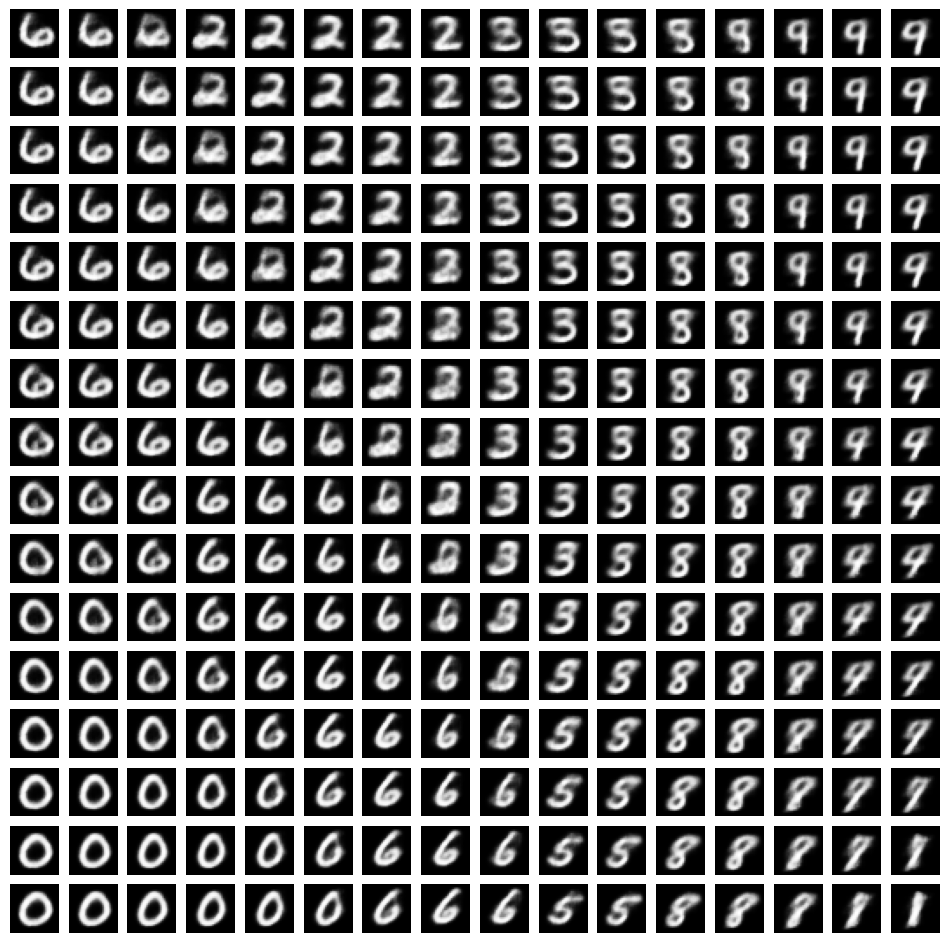

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,12))
k = 0

for i in grid_x:
  for j in grid_y:
    ax = plt.subplot(n,n,k+1)

    input = tf.constant([[i,j]])
    out = model.decoder.predict(input)[0][...,0]
    plt.imshow(out, cmap="Greys_r")
    plt.axis('off')
    k+=1